In [78]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score, f1_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation # а также другие алгоритмы

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

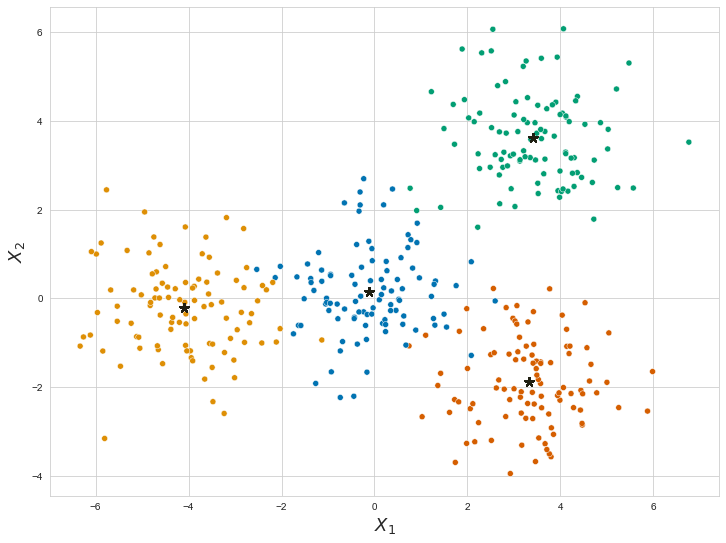

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for i in range(self.max_iter):
            print(f"\r{i}/{self.max_iter} iteration", end="")

            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))

            #dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(np.array(dists), axis=0)

            # Пересчитаем центр масс для каждого кластера
            new_centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[cluster_labels == label].mean(axis=0)
                new_centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

            # dont want to wait for too long, if centroids are already converged
            if np.allclose(np.array(new_centroids), np.array(centroids)):
                break
            else:
                centroids = new_centroids

        self.centroids = np.array(centroids)
        print(f"\rdone with {i}/{self.max_iter} iterations, {self.init}")
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        return np.argmin(np.array(dists), axis=0).astype(int)
                

    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        # euclidean norm - np.linalg.norm
        # by definition, dist(a, b) = euclidean_norm(a-b)
        # So we use broadcasting to subtract centroid from each row of X
        # and we apply np.linalg.norm to each row of (X - centroid); axis=1 does the work.
        # https://stackoverflow.com/a/1401828
        return np.linalg.norm(X - centroid, axis=1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

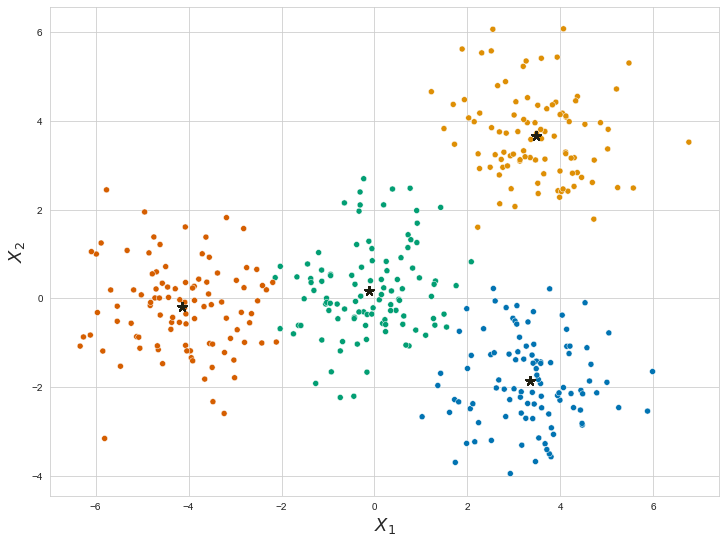

done with 4/300 iterations, sample


Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
clt = MyKMeans(4, init="sample", visualize=True)
clt.fit(X)

In [8]:
cluster_labels = clt.predict(X)
print(np.unique(cluster_labels))

[0 1 2 3]


In [9]:
np.set_printoptions(formatter={'float': lambda x: f"{x:0.3f}"})  # to print only 3 decimal digits for np.arrays

si = 53
print(f"{X[si]} belongs to cluster {cluster_labels[si]} with centroid {clt.centroids[cluster_labels[si]]}")

[-3.669 -0.185] belongs to cluster 3 with centroid [-4.140 -0.199]


Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

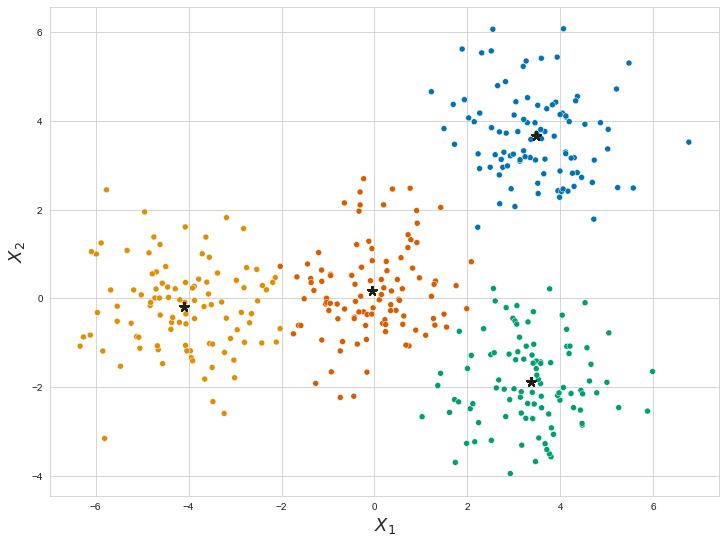

done with 4/300 iterations, sample


Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [10]:
clt = MyKMeans(4, init="sample", visualize=True)
clt.fit(X)
# clt.predict(X);

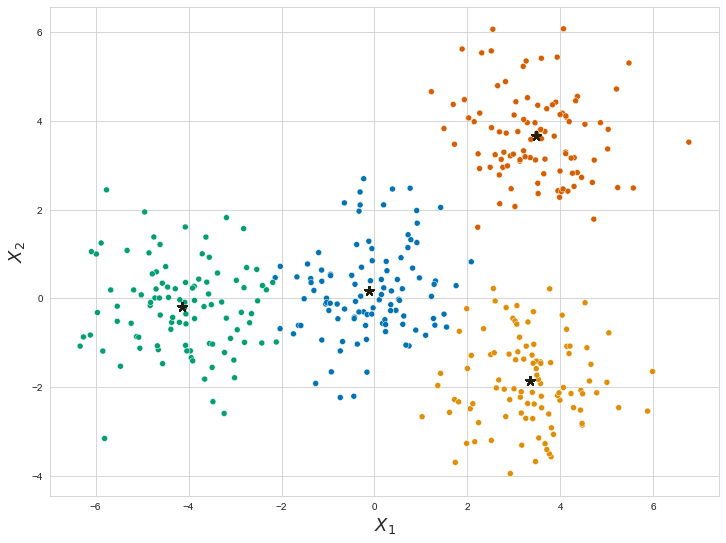

done with 8/300 iterations, random


Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [11]:
clt = MyKMeans(4, init="random", visualize=True)
clt.fit(X)

<font size=3 color='gren'><b>I don't see a simple connection between init method and how many iterations needed for algorithm to converge.
Also it's not stable: "random" gives me 4, 5, 6, 13 iterations from launch to launch. The same for "sample".
The number of steps to achieve convergence changes with each run for both methods more drastically than it changes between methods.</b></font>

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity (homogeneity_score)
* completeness (completeness_score)
* v_measure (v_measure_score)
* silhouette (silhouette_score)

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [12]:
data = load_digits()
X, y = data.data, data.target

In [13]:
# what data we have?
n_samples, n_features = X.shape
print(f"true_labels={np.unique(y)}, {n_samples} samples , {n_features} features")

true_labels=[0 1 2 3 4 5 6 7 8 9], 1797 samples , 64 features


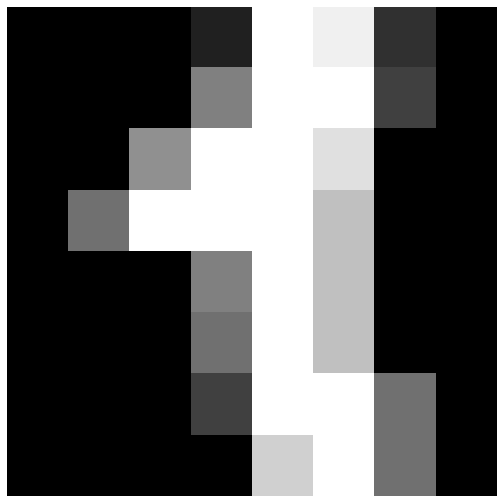

In [14]:
plt.imshow(X[456].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [15]:
# similar analysis for kMeans, https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
# performance evaluation https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
# https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html


def algorithm_selection(X, distances, algorithms, metrics=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    metrics_data = []
    for affinity in distances:
        for linkage in algorithms:
            clustering = AgglomerativeClustering(n_clusters=10, linkage=linkage, affinity=affinity)
            clustering.fit_predict(X)

            metrics_data.append({
                "affinity": affinity,
                "linkage": linkage,
                "homo": homogeneity_score(y, clustering.labels_),
                "comp": completeness_score(y, clustering.labels_),
                "v_m": v_measure_score(y, clustering.labels_),
                "silh": silhouette_score(X, clustering.labels_),
                "dummy_score": (clustering.labels_ == y).sum() / y.shape[0],
            })
    
    return pd.DataFrame(metrics_data)

In [16]:
algo_results = algorithm_selection(X, ["euclidean", "l1", "l2", "manhattan", "cosine"], ["single", "complete", "average"])

In [17]:
algo_results

affinity   linkage      homo      comp       v_m      silh  dummy_score
0   euclidean    single  0.005056  0.273755  0.009929 -0.133621     0.099054
1   euclidean  complete  0.590549  0.637772  0.613253  0.119271     0.116305
2   euclidean   average  0.655393  0.782342  0.713263  0.146625     0.122426
3          l1    single  0.005102  0.276237  0.010019 -0.166627     0.099610
4          l1  complete  0.646372  0.686109  0.665648  0.140183     0.097941
5          l1   average  0.566751  0.778942  0.656117  0.089217     0.157485
6          l2    single  0.005056  0.273755  0.009929 -0.133621     0.099054
7          l2  complete  0.590549  0.637772  0.613253  0.119271     0.116305
8          l2   average  0.655393  0.782342  0.713263  0.146625     0.122426
9   manhattan    single  0.005102  0.276237  0.010019 -0.166627     0.099610
10  manhattan  complete  0.646372  0.686109  0.665648  0.140183     0.097941
11  manhattan   average  0.566751  0.778942  0.656117  0.089217     0.157485
12     cosine    single  0.005050  0.273389  0.009916 -0.158250     0.099610
13     cosine  complete  0.528727  0.577415  0.551999  0.088021     0.207012
14     cosine   average  0.648268  0.808762  0.719676  0.129526     0.163050

in fact, 'euclidean' and 'l2' are the same metric, and 'manhattan' and 'l1' too.
we can exclude them:

In [18]:
algo_results[algo_results.affinity.isin(["euclidean", "manhattan", "cosine"])]

affinity   linkage      homo      comp       v_m      silh  dummy_score
0   euclidean    single  0.005056  0.273755  0.009929 -0.133621     0.099054
1   euclidean  complete  0.590549  0.637772  0.613253  0.119271     0.116305
2   euclidean   average  0.655393  0.782342  0.713263  0.146625     0.122426
9   manhattan    single  0.005102  0.276237  0.010019 -0.166627     0.099610
10  manhattan  complete  0.646372  0.686109  0.665648  0.140183     0.097941
11  manhattan   average  0.566751  0.778942  0.656117  0.089217     0.157485
12     cosine    single  0.005050  0.273389  0.009916 -0.158250     0.099610
13     cosine  complete  0.528727  0.577415  0.551999  0.088021     0.207012
14     cosine   average  0.648268  0.808762  0.719676  0.129526     0.163050

'single' linkage always gives bad results, it's said to perform poorly for noisy data.
Let's see how bad it is. We build a histogram of labels, and check how big each predicted cluster is:

<AxesSubplot:ylabel='Count'>

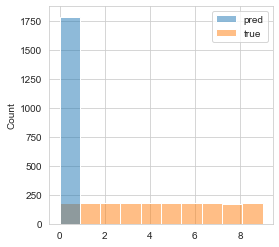

In [19]:
labels = AgglomerativeClustering(n_clusters=10, linkage="single", affinity="l2").fit_predict(X)
plt.figure(figsize=(4, 4))
sns.histplot({"pred": labels, "true": y}, bins=10)

In [20]:
for i in range(10):
    cluster_size = (labels == i).sum()  # how many of digit i we have in labels?
    print(f"claster {i} has {cluster_size} samples")

claster 0 has 1788 samples
claster 1 has 1 samples
claster 2 has 1 samples
claster 3 has 1 samples
claster 4 has 1 samples
claster 5 has 1 samples
claster 6 has 1 samples
claster 7 has 1 samples
claster 8 has 1 samples
claster 9 has 1 samples


So 'single' linkage produces 10 clusters, 9 of them are of one sample, and cluster for zero has almost all samples.
We can say that 'single' linkage is a greedy one. On noisy data it combines samples one by one, into one gigantic cluster, and there is no way to stop it.
For sure, this's why we have some low homogeneity and completeness metrics.

Complete linkage has no such property: at some moment, one cluster becomes big enough, so no more samples can be connected to it, because there are other clusters with lower distances between them.

Let's try linkage="ward" just to see how bad it is.

ward: homo=0.858 compl=0.879 v_m=0.868 silhouette=0.178 matches=0.194


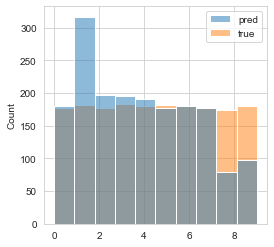

In [21]:
labels = AgglomerativeClustering(n_clusters=10, linkage="ward").fit_predict(X)
plt.figure(figsize=(4, 4))
sns.histplot({"pred": labels, "true": y}, bins=10)

hs = homogeneity_score(y, labels)
cs = completeness_score(y, labels)
vms = v_measure_score(y, labels)
sc = silhouette_score(X, labels)
dummy_score = (labels == y).sum() / y.shape[0]
print(f"ward: homo={hs:.3f} compl={cs:.3f} v_m={vms:.3f} silhouette={sc:.3f} matches={dummy_score:.3f}")

Ward linkage is extremely better.

In [22]:
algo_results[~algo_results.linkage.isin(["single"]) & algo_results.affinity.isin(["euclidean", "manhattan", "cosine"])].sort_values(["linkage"])

affinity   linkage      homo      comp       v_m      silh  dummy_score
2   euclidean   average  0.655393  0.782342  0.713263  0.146625     0.122426
11  manhattan   average  0.566751  0.778942  0.656117  0.089217     0.157485
14     cosine   average  0.648268  0.808762  0.719676  0.129526     0.163050
1   euclidean  complete  0.590549  0.637772  0.613253  0.119271     0.116305
10  manhattan  complete  0.646372  0.686109  0.665648  0.140183     0.097941
13     cosine  complete  0.528727  0.577415  0.551999  0.088021     0.207012

Not that big difference between different affinity metrics. Moreover, for "ward" linkage only euclidean distance works.
Besides, "ward" give highest homogeneity and completeness among all of them.
So we can conclude, that AgglomerativeClustering(n_clusters=10, linkage="ward", affinity="euclidean") is the best one.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [23]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [24]:
fc_data.shape

(10000, 9)

we have 10K cells and 9 features

In [25]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

Looking at FSC-A, we suspect it has outliers, because Q3=1.05 while max=42.95. Very likely SSC-A has outliers as well.
The rest is not so obvious, but let's check them all.

<AxesSubplot:>

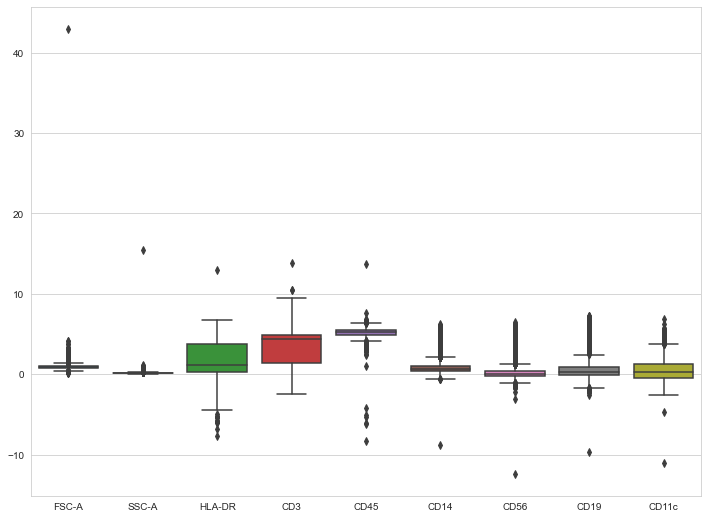

In [26]:
sns.boxplot(data=fc_data)

In [27]:
print("outliers summary for each feature, how many of them below 'minimum' and above 'maximum'")
for column_name in fc_data:
    f_series = fc_data[column_name]
    q1 = f_series.quantile(0.25)
    q3 = f_series.quantile(0.75)
    iqr = q3 - q1
    minimum = q1 - (1.5*iqr)
    maximum = q3 + (1.5*iqr)
    print(f"{column_name:>6}: {f_series[f_series < minimum].shape[0]:>4} below minimum, {f_series[f_series > maximum].shape[0]:>4} above maximum")


outliers summary for each feature, how many of them below 'minimum' and above 'maximum'
 FSC-A:   40 below minimum,  498 above maximum
 SSC-A:    0 below minimum, 1132 above maximum
HLA-DR:   11 below minimum,    1 above maximum
   CD3:    0 below minimum,    3 above maximum
  CD45:  170 below minimum,   12 above maximum
  CD14:    5 below minimum, 1131 above maximum
  CD56:   28 below minimum, 1309 above maximum
  CD19:   16 below minimum, 2055 above maximum
 CD11c:    2 below minimum,  513 above maximum


So FSC-A has obvious outlier, which we'd like to drop. It turned out that it's better to drop outliers one by one, and analyse boxplot after each outlier removal. Most likely a sample is a outlier across all features. So it's removal saves us time not going feature by feature.

<AxesSubplot:>

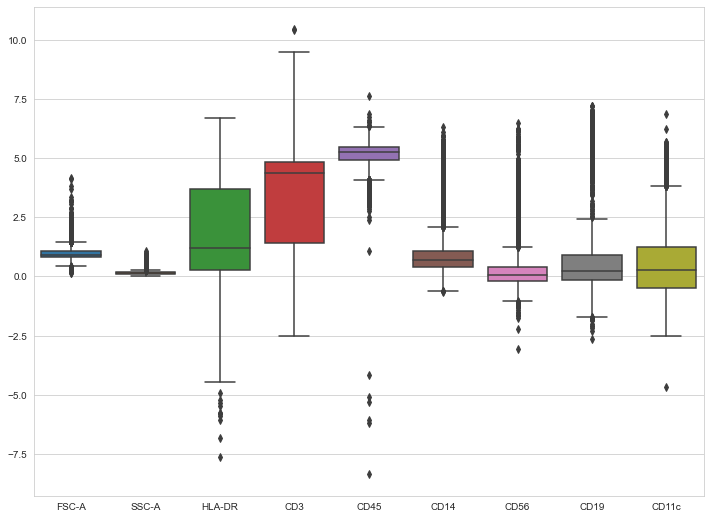

In [28]:
fc_data.drop(fc_data["FSC-A"].idxmax(), inplace=True)
sns.boxplot(data=fc_data)

<font size=3 color='gren'><b>It's much better now. What we can improve: to drop min from CD45.</b></font>

<AxesSubplot:>

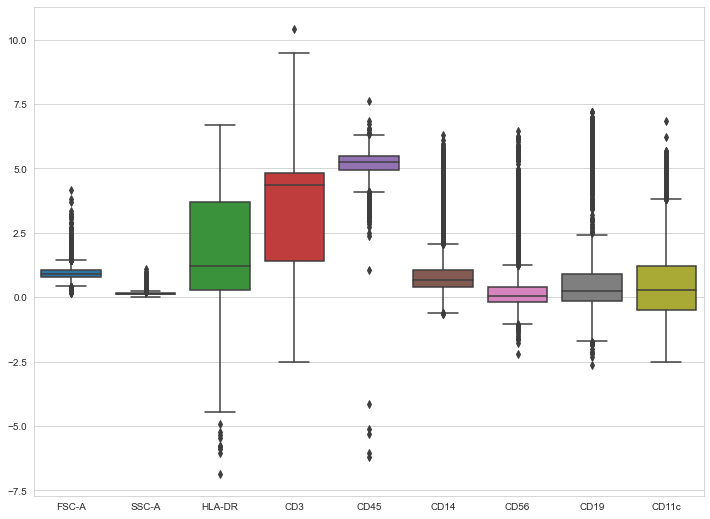

In [29]:
fc_data.drop(fc_data["CD45"].idxmin(), inplace=True)
sns.boxplot(data=fc_data)

<font size=3 color='gren'><b>So this one also helped, but not that much as the first outliers. So we can stop at this point.</b></font>

<Figure size 288x288 with 0 Axes>

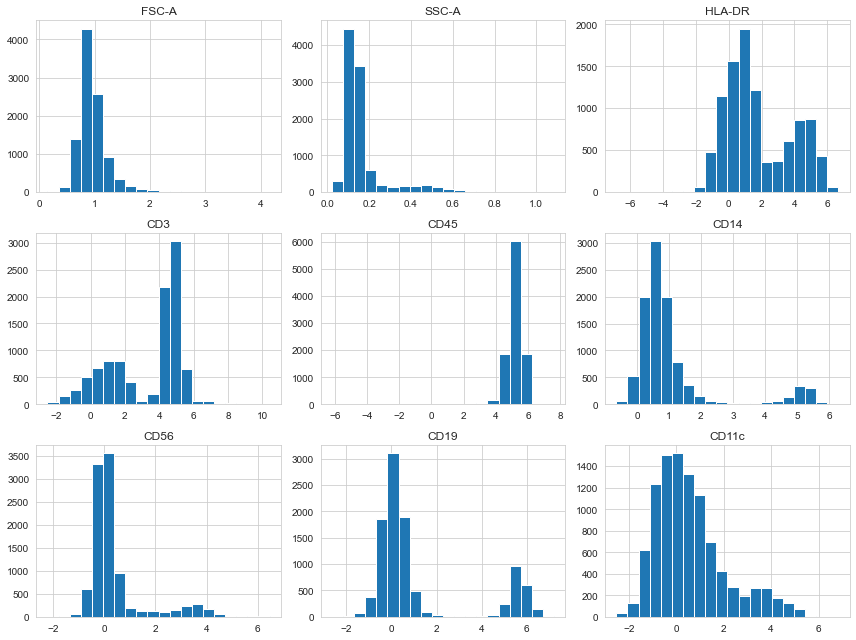

In [30]:
plt.figure(figsize=(4, 4))
fig, axs = plt.subplots(nrows=3, ncols=3)

for idx, column_name in enumerate(fc_data):
    axs[idx//3, idx%3].hist(fc_data[column_name], bins=20)
    axs[idx//3, idx%3].set_title(column_name)

fig.tight_layout()
plt.show()

<font size=3 color='gren'><b>Half of the features has 2-modal distribution.</b></font>

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [31]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """

    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа,
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

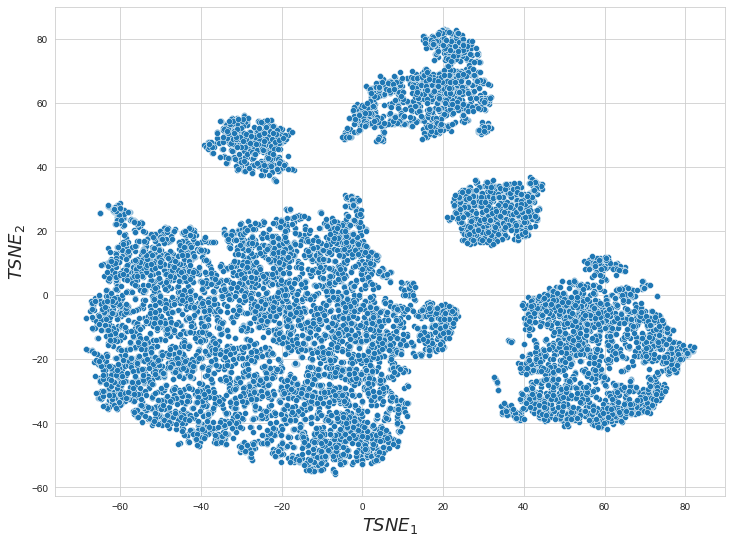

In [32]:
tsne_res = plot_tsne(fc_data)

<font size=3 color='gren'><b>We can say there are 5 clusters here.</b></font>

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

       agglomerative-ward 0.464


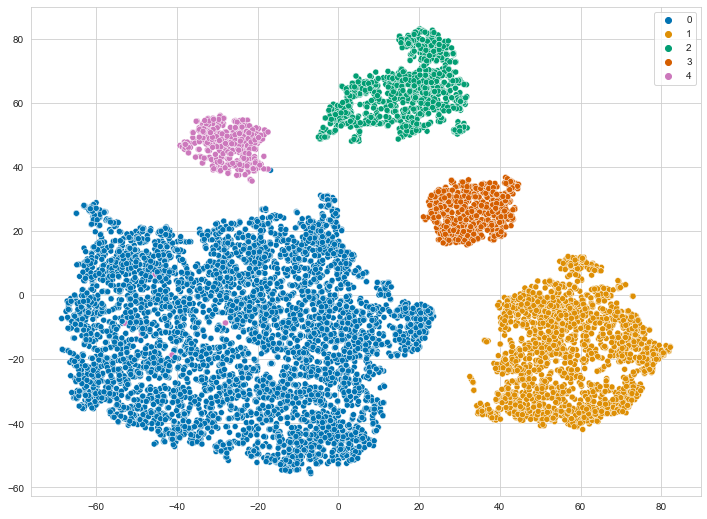

   agglomerative-complete 0.506


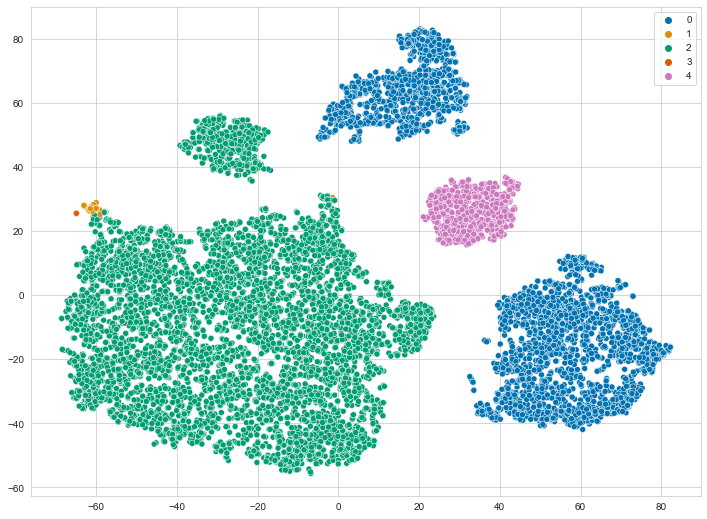

     agglomerative-single 0.198


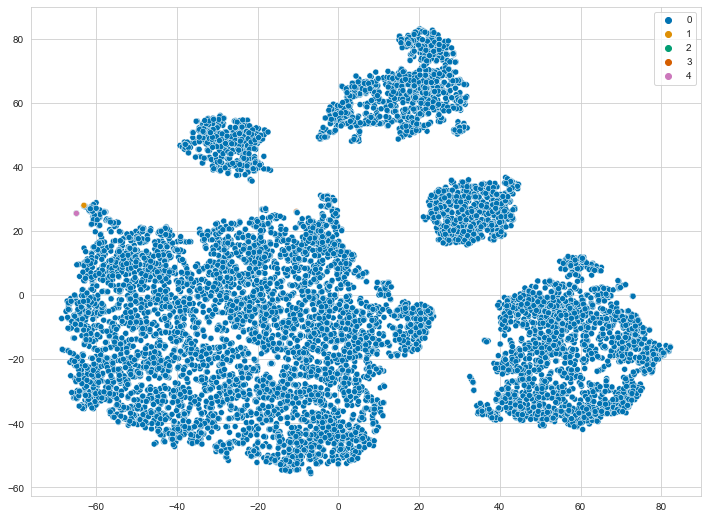

    agglomerative-average 0.602


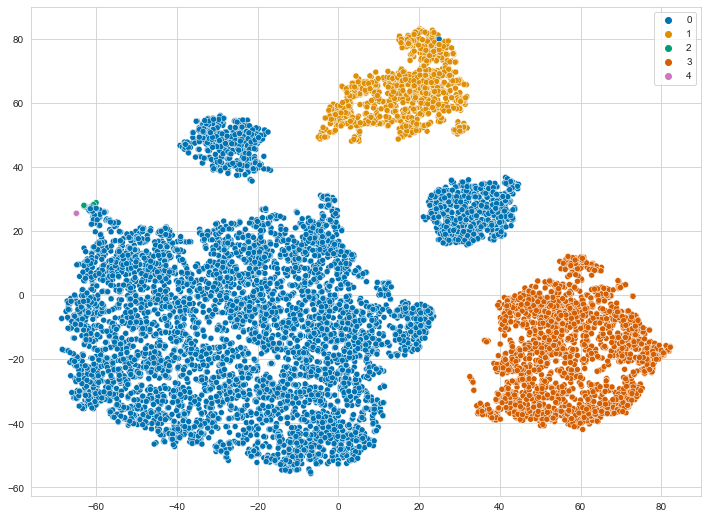

                kmeans-++ 0.351


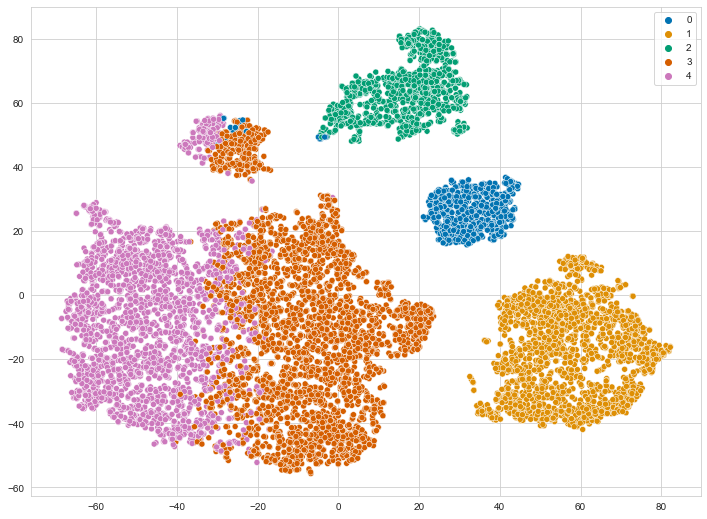

            kmeans-random 0.351


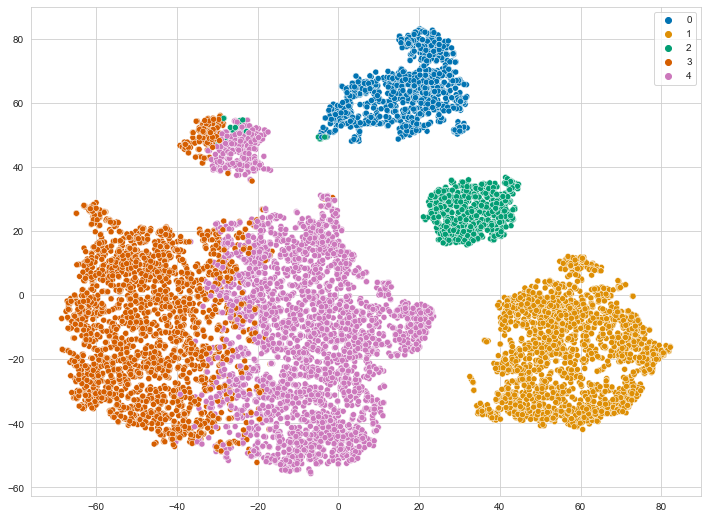

In [33]:
n_clusters = 5
algos = {
    "agglomerative-ward": AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward"),
    f"agglomerative-complete": AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="complete"),
    f"agglomerative-single": AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="single"),
    f"agglomerative-average": AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="average"),
    f"kmeans-++": KMeans(n_clusters=n_clusters, init="k-means++", random_state=SEED),
    f"kmeans-random": KMeans(n_clusters=n_clusters, init="random", random_state=SEED),
    # "affinity": AffinityPropagation(affinity="euclidean", random_state=SEED),
}

colors = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple'}

for name, algo in algos.items():
    labels = algo.fit_predict(fc_data)
    silh = silhouette_score(fc_data, labels, random_state=SEED)
    print(f"{name:>25} {silh:.3f}")

    colored_label = np.array([np.array([colors for l in labels])])

    sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=labels, palette="colorblind")
    plt.show()

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

<font size=3 color='gren'><b>OK, we select the best algo based on silhouette metric, which is agglomerative-average,  silh=0.602
Mostly we can say that each cluster colored in one color, with except of dozes of samples.</b></font>

In [34]:
# lets try to see, can we get better metrics for different n_cluster values?

algos = {}
for k in [3,4,5,6]:
    a = {
        f"{k} agglomerative-ward": AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="ward"),
        f"{k} agglomerative-complete": AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="complete"),
        f"{k} agglomerative-single": AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="single"),
        f"{k} agglomerative-average": AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="average"),
        f"{k} kmeans-++": KMeans(n_clusters=k, init="k-means++", random_state=SEED),
        f"{k} kmeans-random": KMeans(n_clusters=k, init="random", random_state=SEED),
        # "affinity": AffinityPropagation(affinity="euclidean", random_state=SEED),
    }
    algos.update(a)


for name, algo in algos.items():
    labels = algo.fit_predict(fc_data)
    silh = silhouette_score(fc_data, labels, random_state=SEED)
    print(f"{name:>25} {silh:.3f}")


     3 agglomerative-ward 0.610
 3 agglomerative-complete 0.502
   3 agglomerative-single 0.635
  3 agglomerative-average 0.449
              3 kmeans-++ 0.610
          3 kmeans-random 0.610
     4 agglomerative-ward 0.613
 4 agglomerative-complete 0.471
   4 agglomerative-single 0.198
  4 agglomerative-average 0.511
              4 kmeans-++ 0.611
          4 kmeans-random 0.611
     5 agglomerative-ward 0.464
 5 agglomerative-complete 0.506
   5 agglomerative-single 0.198
  5 agglomerative-average 0.602
              5 kmeans-++ 0.351
          5 kmeans-random 0.351
     6 agglomerative-ward 0.310
 6 agglomerative-complete 0.598
   6 agglomerative-single 0.156
  6 agglomerative-average 0.611
              6 kmeans-++ 0.364
          6 kmeans-random 0.363


     agglomerative-single 0.635


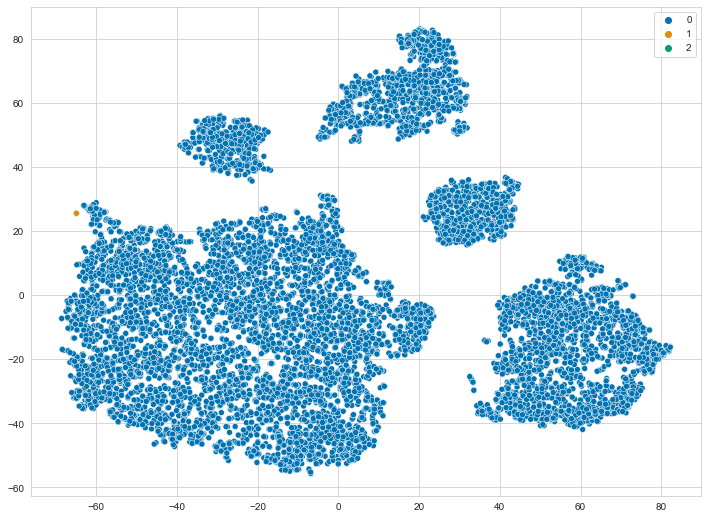

In [35]:
n_clusters = 3
algos = {
    f"agglomerative-single": AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="single")
}

colors = {0: 'black', 1: 'red', 2: 'blue'}

for name, algo in algos.items():
    labels = algo.fit_predict(fc_data)
    silh = silhouette_score(fc_data, labels, random_state=SEED)
    print(f"{name:>25} {silh:.3f}")

    colored_label = np.array([np.array([colors for l in labels])])

    sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=labels, palette="colorblind")
    plt.show()

<font size=3 color='gren'><b>Although the agglomerative-single with 3 clusters gives the best silhouette score = 0.635, clusterization doesn't reflect the types of cells basing on the marker's expression.</b></font>

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Cell surface marker's expression per cell type:

CD3 and CD56 -> T cells<br>
CD45 -> Hematopoietic cells<br>
CD19 -> B-cells<br>
CD11c and CD14 -> Monocytes + HLA-DR<br>
https://www.abcam.com/primary-antibodies/human-cd-antigen-guide


Для начала нарисуем все это безобразие:

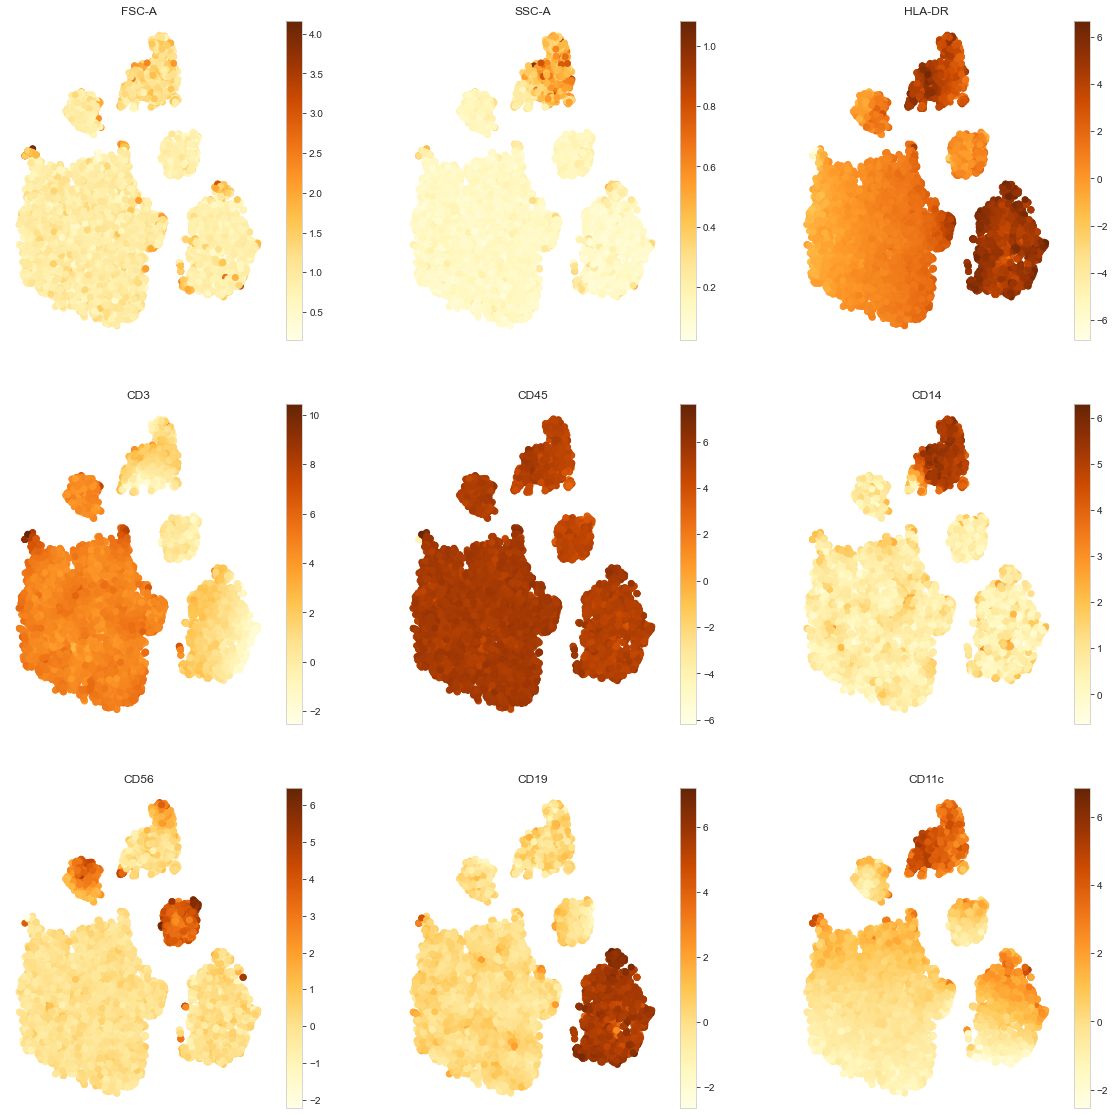

In [36]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [37]:
clustering = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="average")
labels = clustering.fit_predict(fc_data)
print(f"silhouette={silhouette_score(fc_data, labels, random_state=SEED):.3f}")

np.unique(labels, return_counts=True)

silhouette=0.602


(array([0, 1, 2, 3, 4], dtype=int64),
 array([6850, 1097,   11, 2035,    5], dtype=int64))

In [38]:
cell_type_cluster_map = {0: "T_cells",
                         1: "Monocyte",
                         2: "Other cells",
                         3: "B_cells",
                         4: "Other cells"}

<font size=3 color='gren'><b>So we have 5 clusters, and 4 type of cells.</b></font>

In [39]:
labeled_fc_data = fc_data.assign(Population=labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

<AxesSubplot:ylabel='Count'>

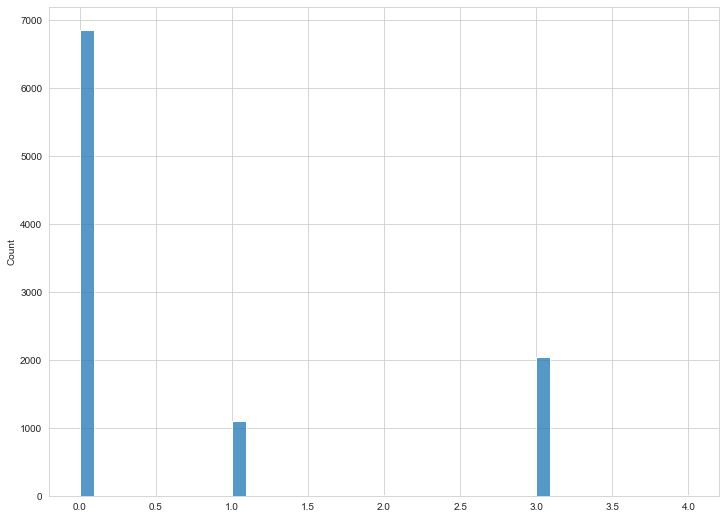

In [40]:
sns.histplot(labels)

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [41]:
labeled_fc_data.to_csv('labeled_fc.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [68]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(fc_data, labeled_fc_data['Population'])

In [70]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [71]:
log_reg = LogisticRegression()
log_reg.fit(scaler.transform(X_train), y_train)
y_pred = log_reg.predict(scaler.transform(X_test))

In [72]:
# Оцените качество полученной модели при помощи f1_score(average="macro")
f1_score(y_test, y_pred, average = 'macro')

0.9159809091346315

In [73]:
# Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов
SEED = 666
random.seed(SEED)
np.random.seed(SEED)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(fc_data, labeled_fc_data['Population'])

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [76]:
log_reg = LogisticRegression(class_weight = "balanced")
log_reg.fit(scaler.transform(X_train), y_train)
y_pred = log_reg.predict(scaler.transform(X_test))

In [77]:
# Оцените качество полученной модели при помощи f1_score(average="macro")
f1_score(y_test, y_pred, average = 'macro')

0.9368141151186135

<font size=3 color='gren'><b>The score increased when balancing the classes.</b></font>

In [79]:
# Let's let's train a model using a Random Forest on the original imbalanced dataset
SEED = 666
random.seed(SEED)
np.random.seed(SEED)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(fc_data, labeled_fc_data['Population'])

In [81]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [82]:
log_reg = RandomForestClassifier()
log_reg.fit(scaler.transform(X_train), y_train)
y_pred = log_reg.predict(scaler.transform(X_test))

In [83]:
# Оцените качество полученной модели при помощи f1_score(average="macro")
f1_score(y_test, y_pred, average = 'macro')

0.9636727369204005

<font size=3 color='gren'><b>As we can see, Random Forest predicts better on the unbalanced data.</b></font>

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

<font size=3 color='gren'><b> Sakura in Tokyo</b></font>

![Sakura in Tokyo](https://resources.matcha-jp.com/resize/720x2000/2020/01/21-95442.jpeg)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**